https://www.pymc.io/projects/examples/en/latest/causal_inference/regression_discontinuity.html

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

In [2]:
RANDOM_SEED = 123
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'

In [3]:
# define true parameters
threshold = 0.0
treatment_effect = 0.7
N = 1000
sd = 0.3  # represents change between pre and post test with zero measurement error

# No measurement error, but random change from pre to post
df = (
    pd.DataFrame.from_dict({"x": rng.normal(size=N)})
    .assign(treated=lambda x: x.x < threshold)
    .assign(y=lambda x: x.x + rng.normal(loc=0, scale=sd, size=N) + treatment_effect * x.treated)
)

df

,x,treated,y
0,-0.989121,True,0.050794
1,-0.367787,True,-0.181418
2,1.287925,False,1.345912
3,0.193974,False,0.430915
4,0.920231,False,1.229825
...,...,...,...
995,-1.246726,True,-0.819665
996,0.090428,False,0.006909
997,0.370658,False,-0.027703
998,-1.063268,True,0.008132


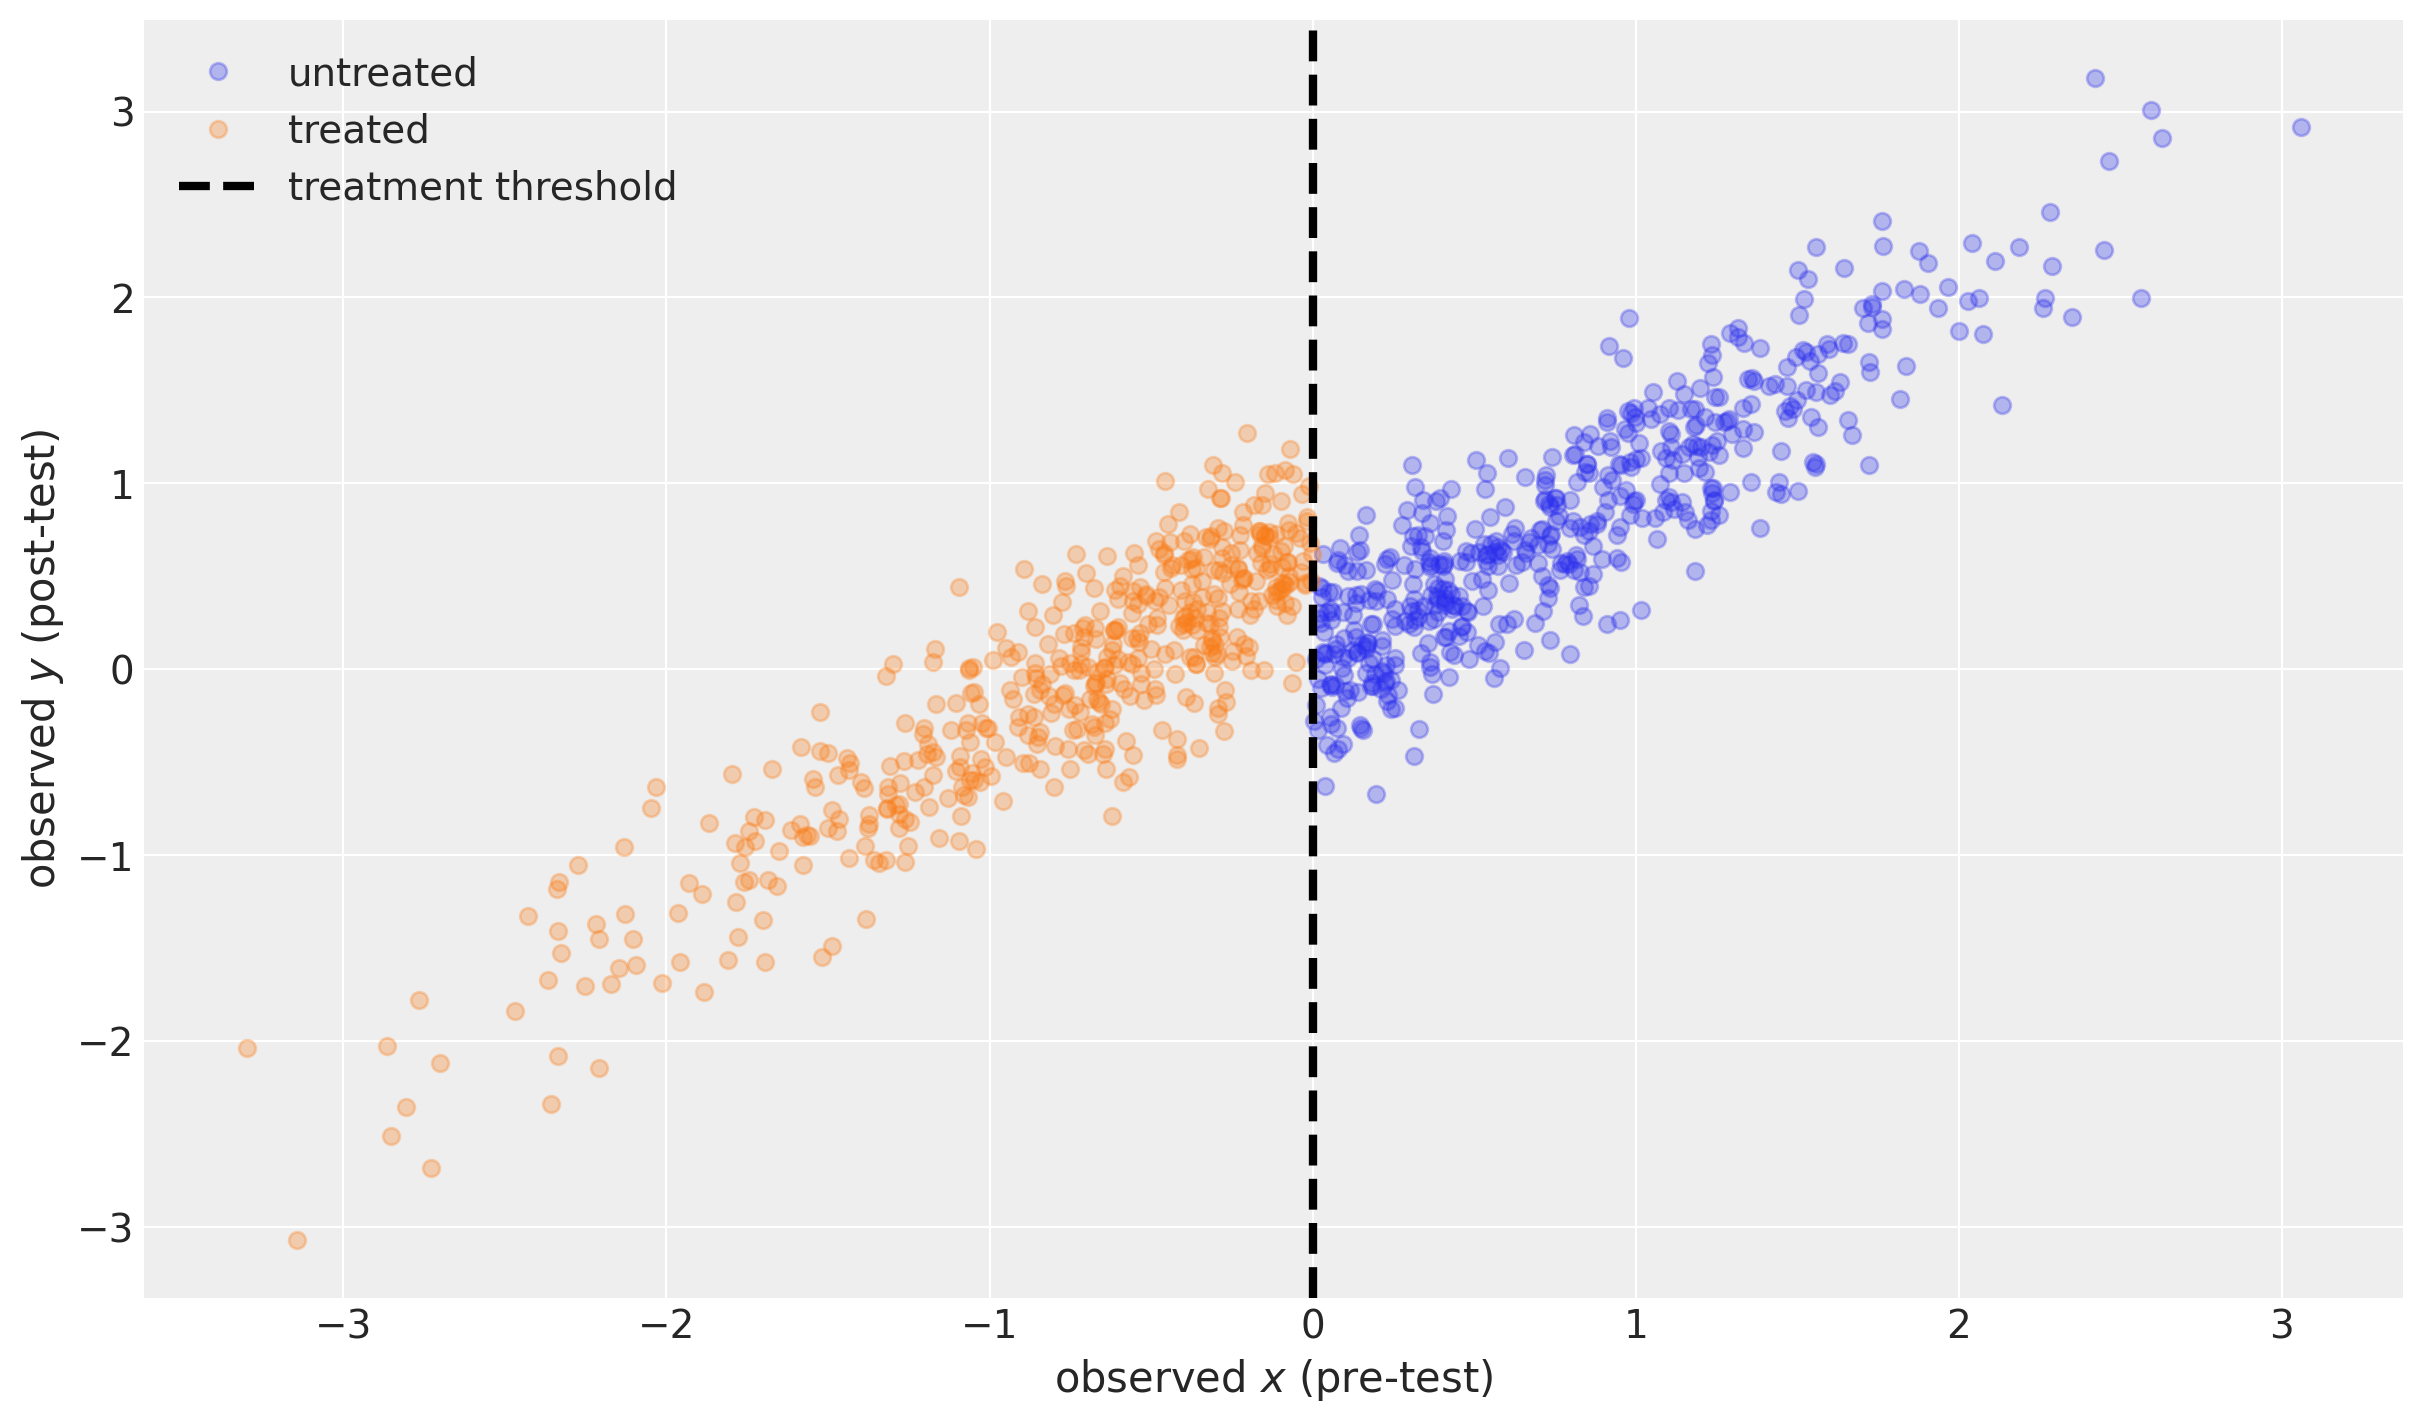

In [4]:
def plot_data(df):
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.plot(df.x[~df.treated], df.y[~df.treated], "o", alpha=0.3, label="untreated")
    ax.plot(df.x[df.treated], df.y[df.treated], "o", alpha=0.3, label="treated")
    ax.axvline(x=threshold, color="k", ls="--", lw=3, label="treatment threshold")
    ax.set(xlabel=r"observed $x$ (pre-test)", ylabel=r"observed $y$ (post-test)")
    ax.legend()
    return ax


plot_data(df);

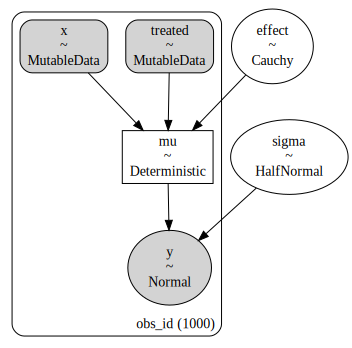

In [5]:
with pm.Model() as model:
    x = pm.MutableData("x", df.x, dims="obs_id")
    treated = pm.MutableData("treated", df.treated, dims="obs_id")
    sigma = pm.HalfNormal("sigma", 1)
    delta = pm.Cauchy("effect", alpha=0, beta=1)
    mu = pm.Deterministic("mu", x + (delta * treated), dims="obs_id")
    pm.Normal("y", mu=mu, sigma=sigma, observed=df.y, dims="obs_id")

pm.model_to_graphviz(model)

In [6]:
with model:
    idata = pm.sample(random_seed=RANDOM_SEED)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


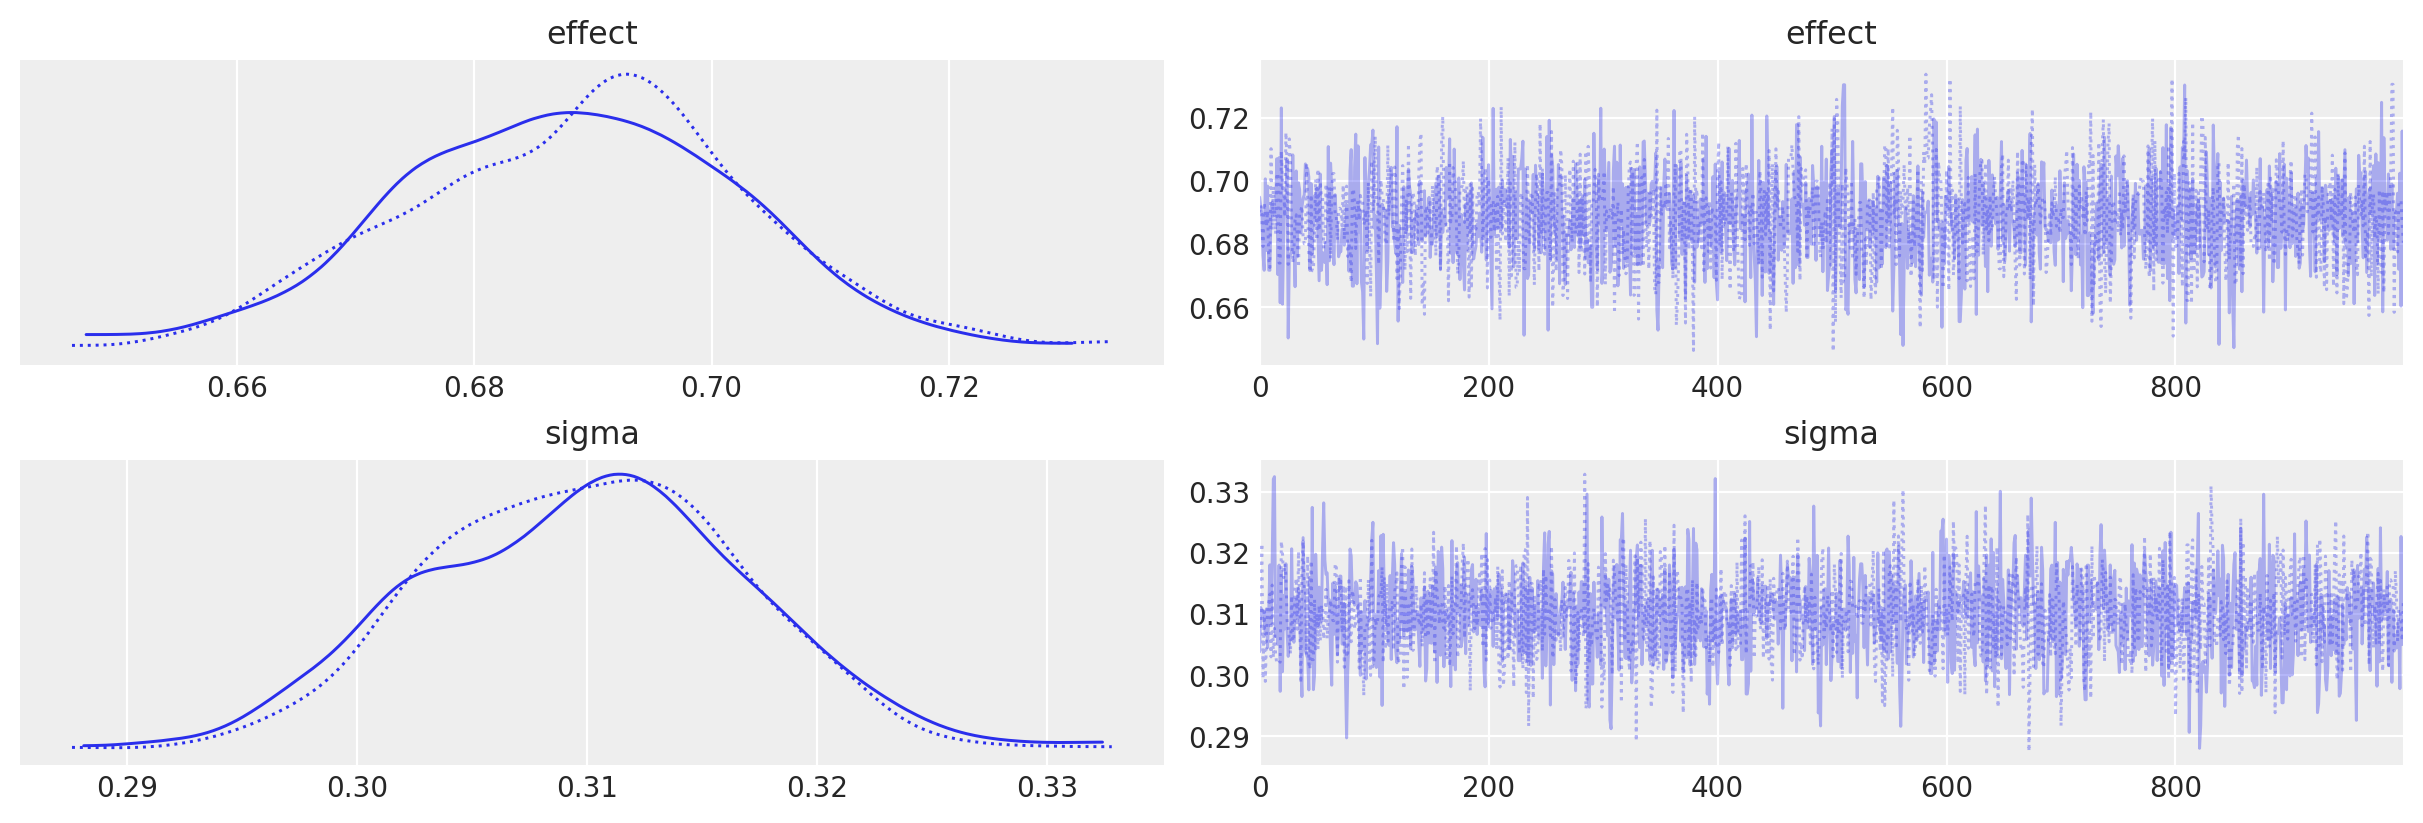

In [7]:
az.plot_trace(idata, var_names=["effect", "sigma"]);

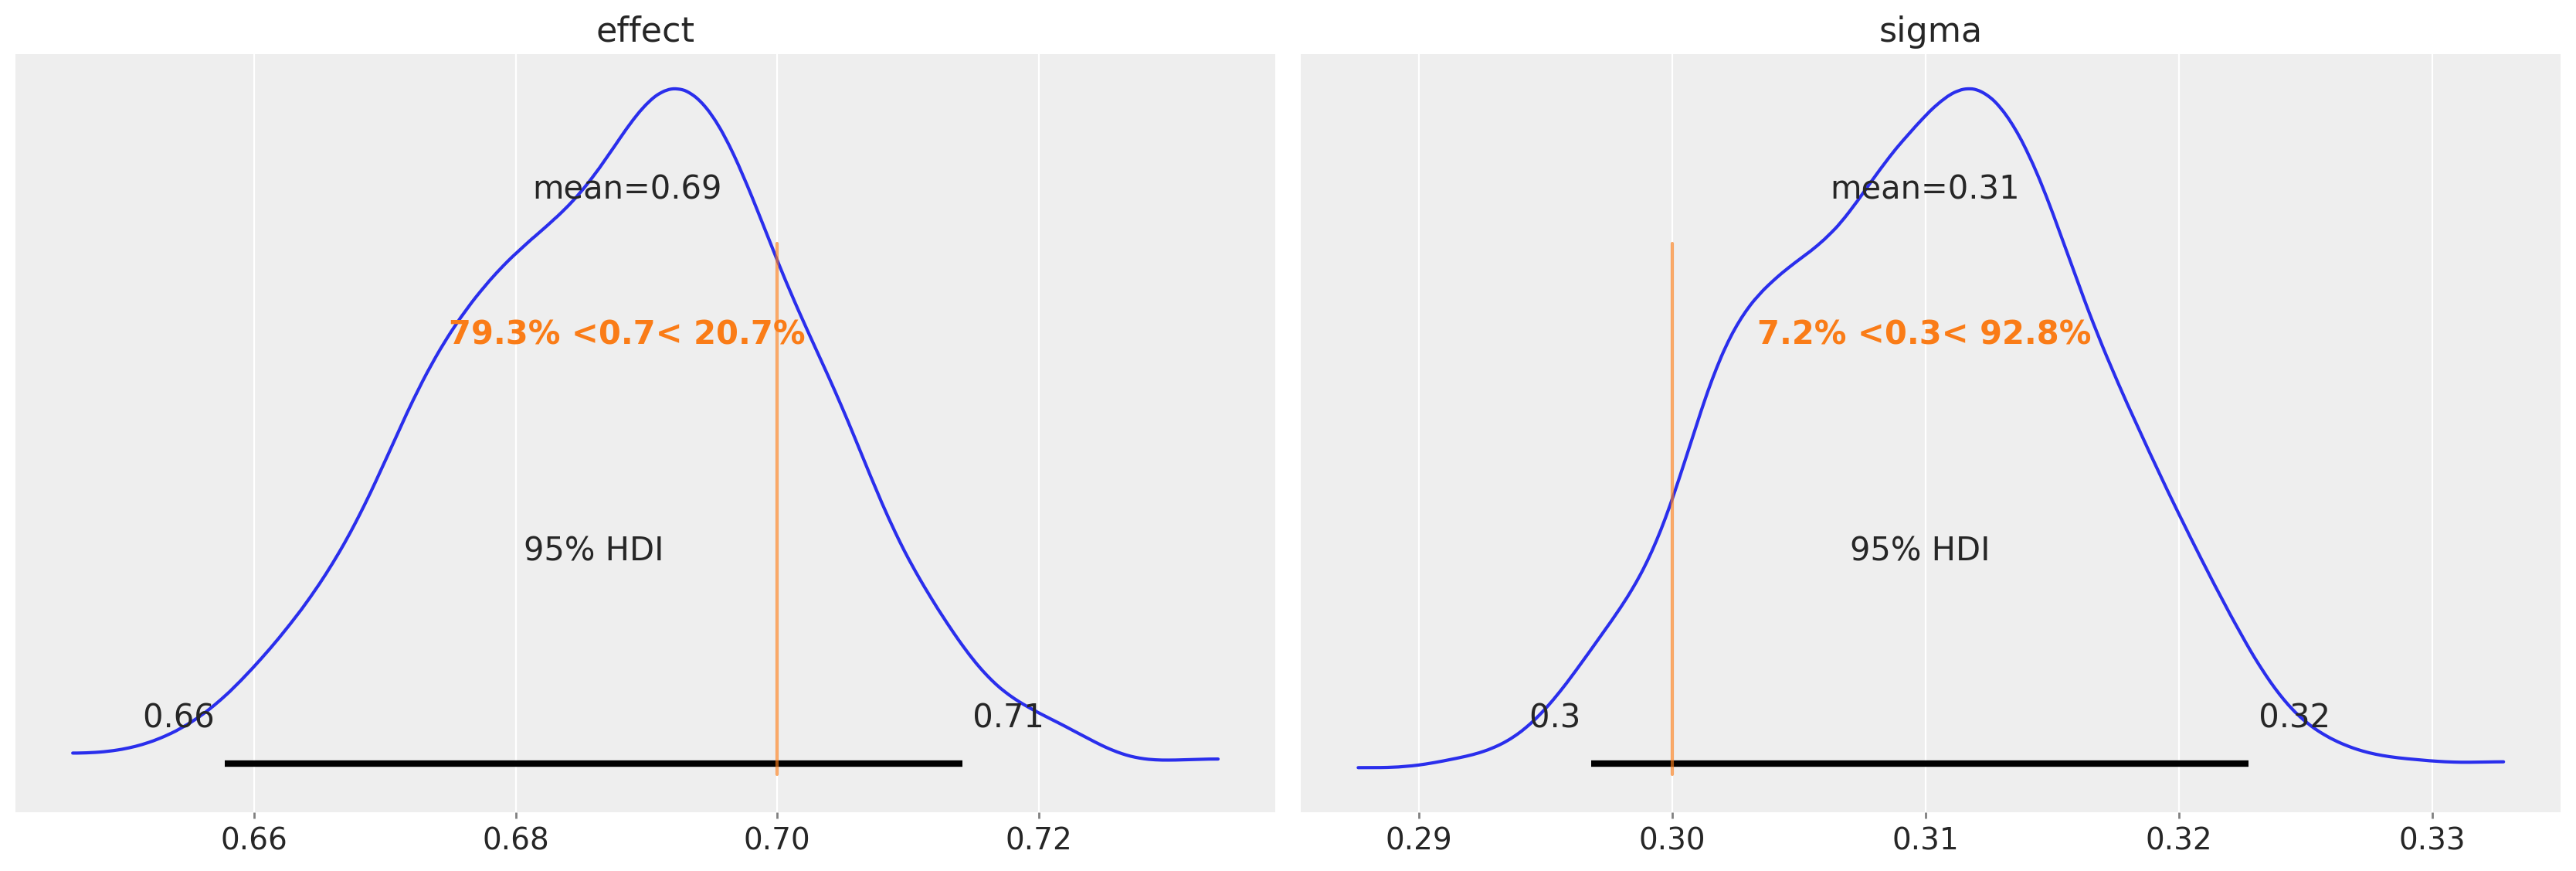

In [8]:
az.plot_posterior(
    idata, var_names=["effect", "sigma"], ref_val=[treatment_effect, sd], hdi_prob=0.95
);

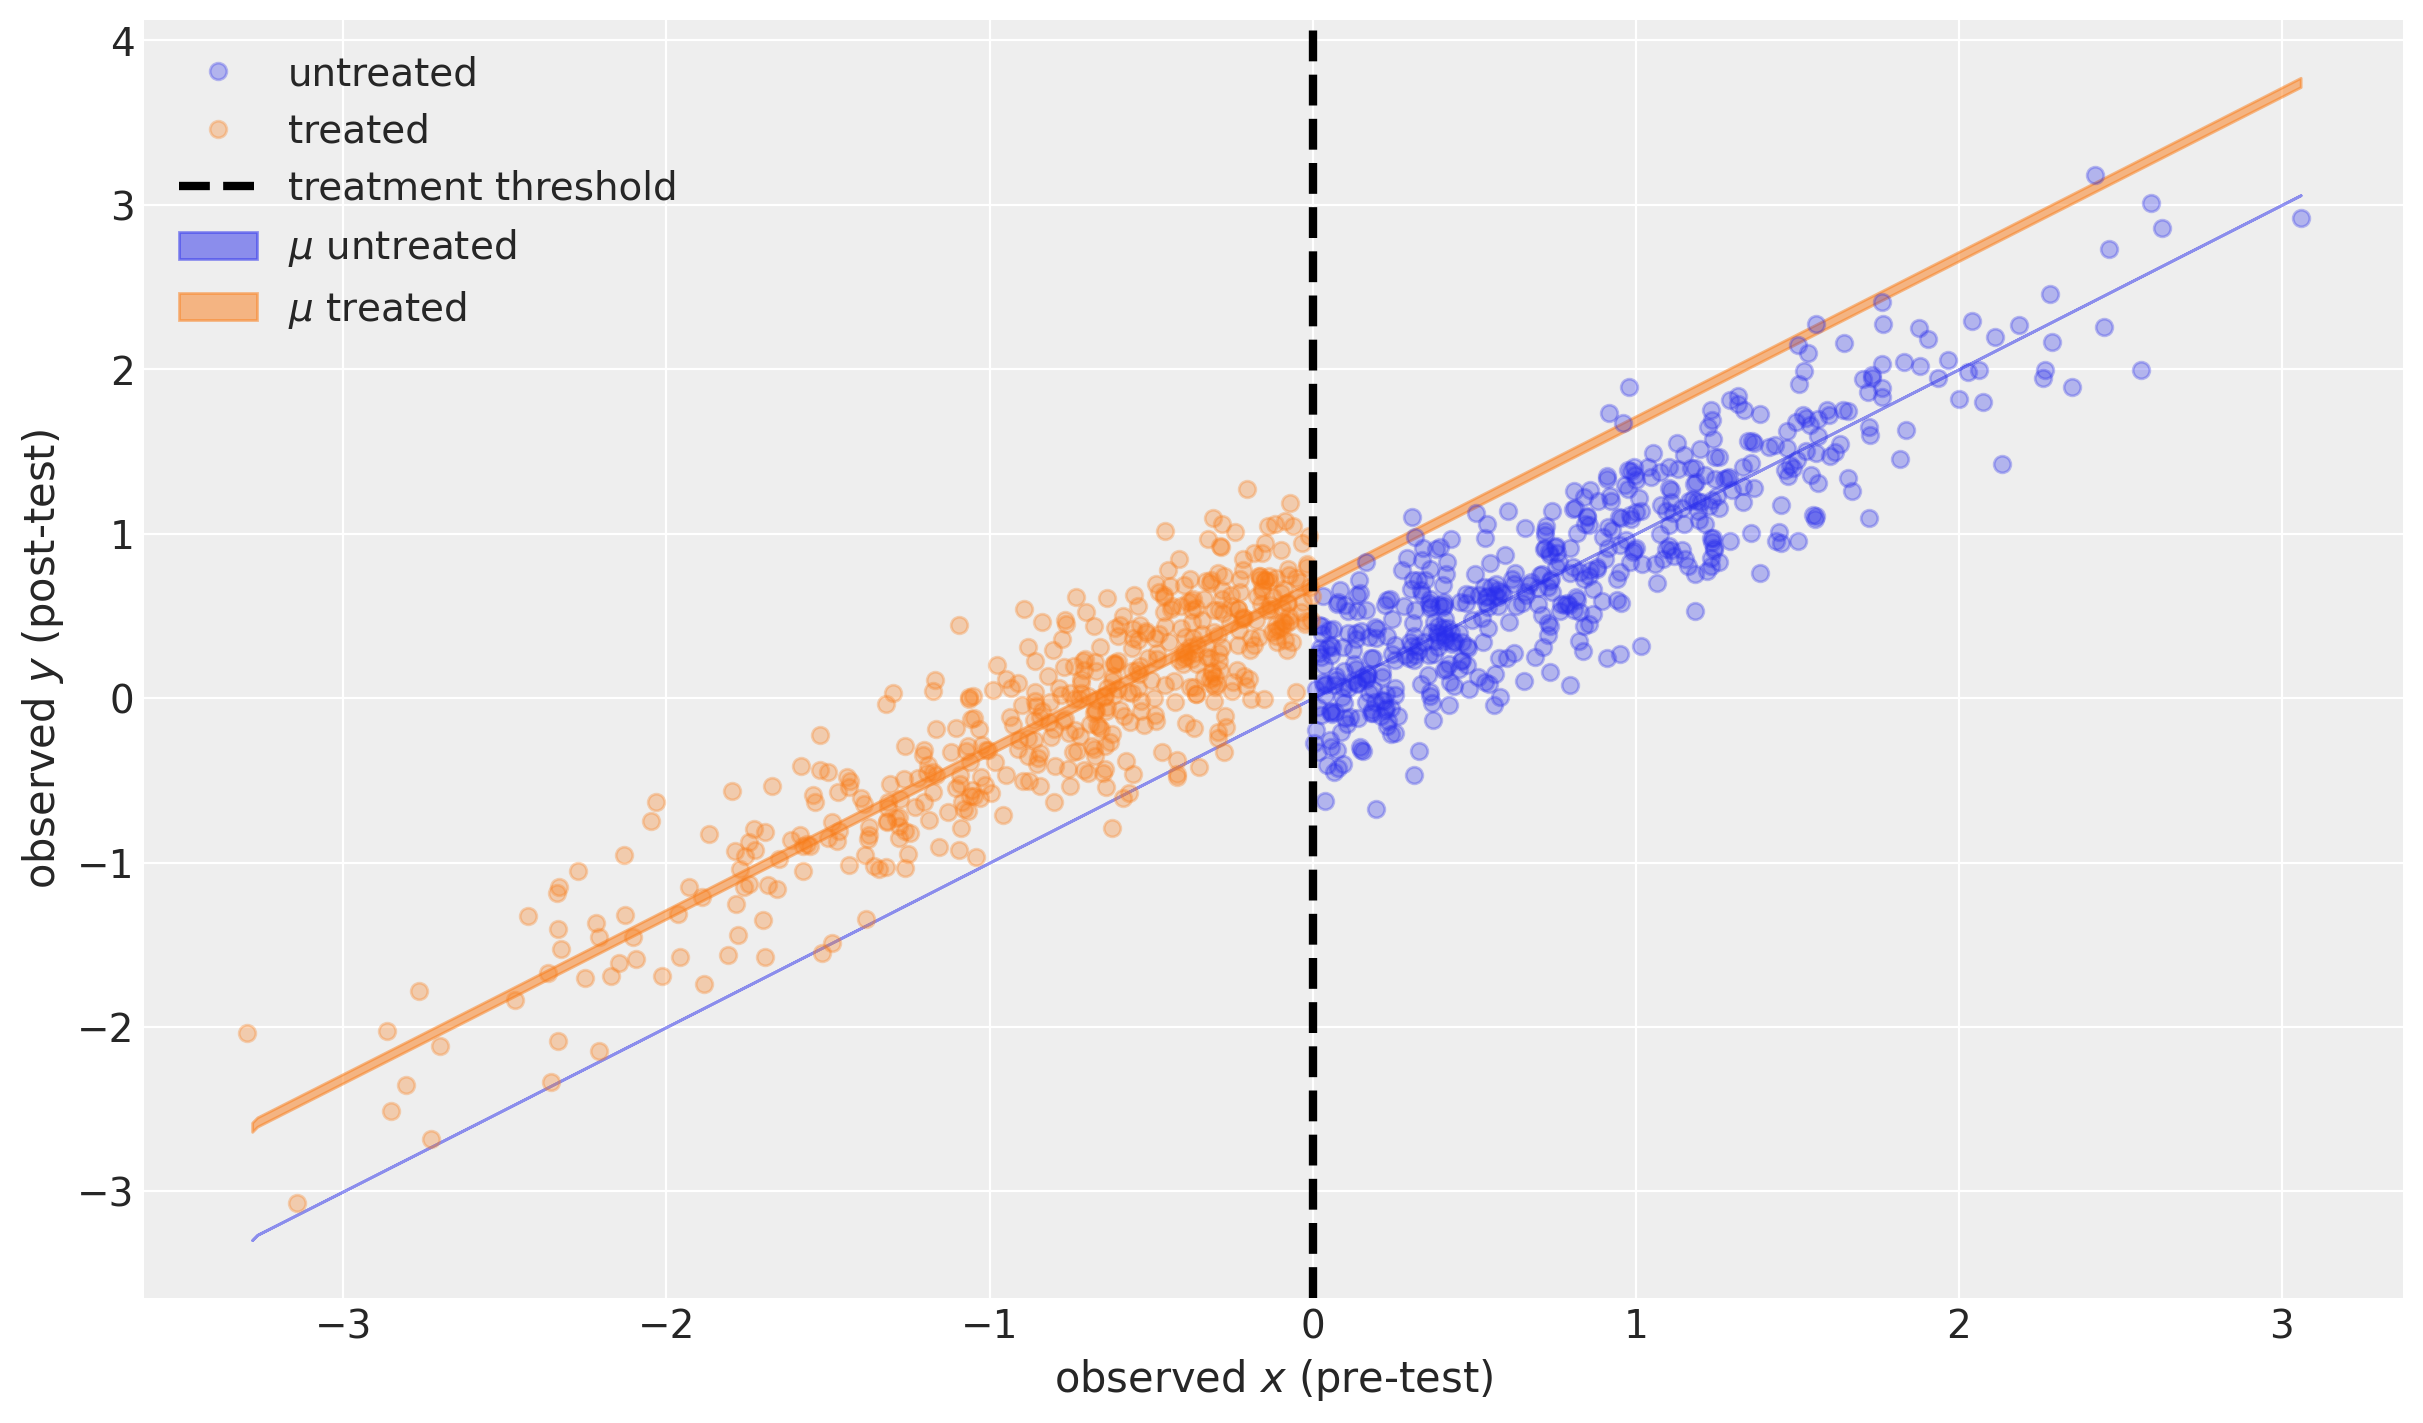

In [9]:
# MODEL EXPECTATION WITHOUT TREATMENT ------------------------------------
# probe data
_x = np.linspace(np.min(df.x), np.max(df.x), 500)
_treated = np.zeros(_x.shape)

# posterior prediction (see technical note above)
with model:
    pm.set_data({"x": _x, "treated": _treated})
    ppc = pm.sample_posterior_predictive(idata, var_names=["mu", "y"])

# plotting
ax = plot_data(df)
az.plot_hdi(
    _x,
    ppc.posterior_predictive["mu"],
    color="C0",
    hdi_prob=0.95,
    ax=ax,
    fill_kwargs={"label": r"$\mu$ untreated"},
)

# MODEL EXPECTATION WITH TREATMENT ---------------------------------------
# probe data
_x = np.linspace(np.min(df.x), np.max(df.x), 500)
_treated = np.ones(_x.shape)

# posterior prediction (see technical note above)
with model:
    pm.set_data({"x": _x, "treated": _treated})
    ppc = pm.sample_posterior_predictive(idata, var_names=["mu", "y"])

# plotting
az.plot_hdi(
    _x,
    ppc.posterior_predictive["mu"],
    color="C1",
    hdi_prob=0.95,
    ax=ax,
    fill_kwargs={"label": r"$\mu$ treated"},
)
ax.legend()

In [10]:
!pip install watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.2 MB/s eta 0:00:00


In [11]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,aeppl,xarray

Last updated: Fri Dec 15 2023

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

pytensor: 2.14.2
aeppl   : not installed
xarray  : 2023.7.0

numpy     : 1.23.5
arviz     : 0.15.1
matplotlib: 3.7.1
pymc      : 5.7.2
pandas    : 1.5.3

Watermark: 2.4.3

